In [1]:
# 基本库
import os
import pandas as pd
import numpy as np
import time
import joblib

#工具库
from utils import *

#深度学习
np.random.seed(1337)  # for reproducibility

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from sklearn.metrics import  f1_score,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Encoding
def trans(str1):
    a = []
    dic = {'A':1,'B':0,'U':0,'J':0,'Z':0,'O':0,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20,'X':0}
    for i in range(len(str1)):
        a.append(dic.get(str1[i]))
    return a

def Encoding(df1, df2):
    #全序列
    df1['encode'] = df1['seq'].apply(lambda x: trans(x))
    df2['encode'] = df2['seq'].apply(lambda x: trans(x))
    return df1,df2

In [3]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    #函数开始时创建盛放loss与acc的容器
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}
    
    #按照batch来进行追加数据
    def on_batch_end(self, batch, logs={}):
        #每一个batch完成后向容器里面追加loss，acc
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('accuracy'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_accuracy'))

    def on_epoch_end(self, batch, logs={}):
        # 每一个epoch完成后向容器里面追加loss，acc
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('accuracy'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_accuracy'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
            plt.grid(True)
            plt.xlabel(loss_type)
            plt.ylabel('acc-loss')
            plt.legend(loc="upper right")
            plt.show()

In [3]:
#生成train_test集

def createTrainTestData(df1, df2):
    ## Label
    y_train = df1.is_del
    y_train = np.array(y_train).reshape(-1,1)
    y_test = df2.is_del
    y_test = np.array(y_test).reshape(-1,1)
    #reshape(-1,1)
    #行数-1，列数1
    #指定为-1的时候，其行或列会随机分配一个数据（自动计算）


    # 神经网络（变异前序列）
    X_test_1 = np.array(df2.iloc[:,-1])
    X_train_1 = np.array(df1.iloc[:,-1])

    # （生物特征）(归一化)
    # X_test_2 = minmaxscaler(df2.iloc[:,4:-1])
    # X_train_2 = minmaxscaler(df1.iloc[:,4:-1])
    # X_test_2 = feature_normalize(df2.iloc[:,4:-1])
    # X_train_2 = feature_normalize(df1.iloc[:,4:-1])
    X_test_2 = df2.iloc[:,5:-1]
    X_train_2 = df1.iloc[:,5:-1]
    
    return y_train, y_test, X_train_1, X_test_1, X_train_2, X_test_2

In [ ]:
from sklearn.metrics import roc_auc_score

 
# AUC for a binary classifier
def auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)
#------------------------------------------------------------------------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N
#-----------------------------------------------------------------------------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

#接着在模型的compile中设置metrics

In [9]:
#变量初始化
seed=113

# Embedding
max_features = 21
maxlen = 1500
embedding_size = 128

# Convolution
#filter_length = 3
nb_filter = 64
pool_length = 2

# LSTM
# lstm_output_size = 20
lstm_output_size = 70

# Training
batch_size = 128
nb_epoch = 40

#特征选择
rfe = joblib.load('Feature_selected_1/lightgbm_feature_select_20.rfe')

28494 train sequences
3167 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3167, 1500)
X_train_1 shape: (28494, 1500)
X_test_2 shape: (3167, 1085)
X_train_2 shape: (28494, 1085)
Build model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_22 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 745, 64)           256       
___________________________________________

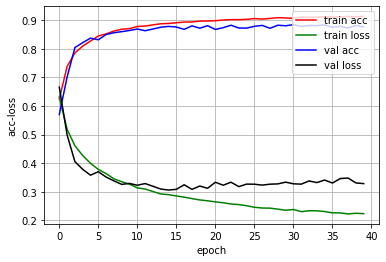

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_24 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 745, 64)           256       
___________________________________________

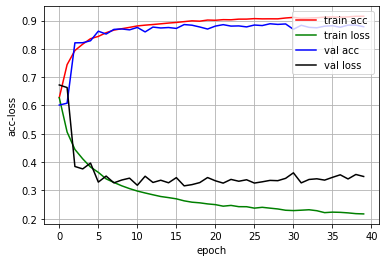

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_26 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 745, 64)           256       
___________________________________________

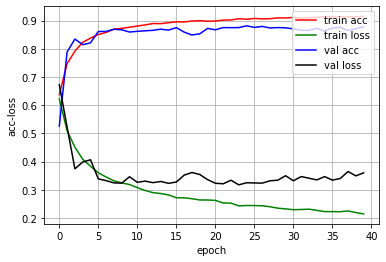

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 745, 64)           256       
___________________________________________

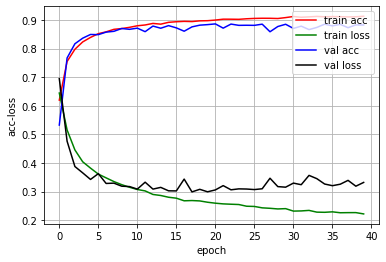

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_30 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 745, 64)           256       
___________________________________________

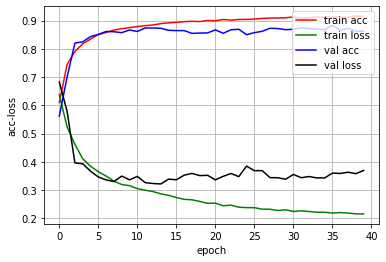

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_32 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 745, 64)           256       
___________________________________________

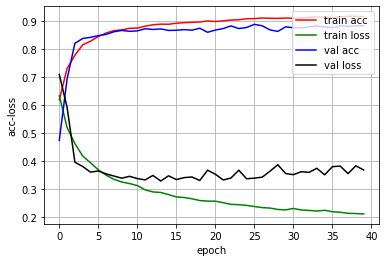

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_34 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 745, 64)           256       
___________________________________________

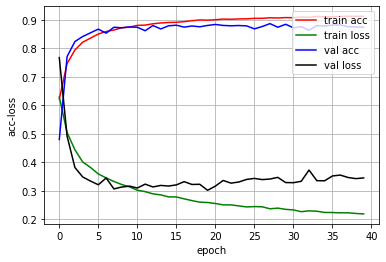

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_36 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 745, 64)           256       
___________________________________________

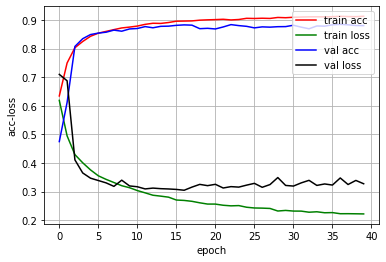

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_38 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 745, 64)           256       
___________________________________________

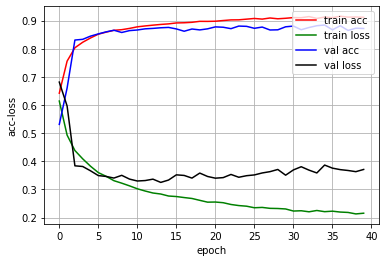

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_40 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 745, 64)           256       
___________________________________________

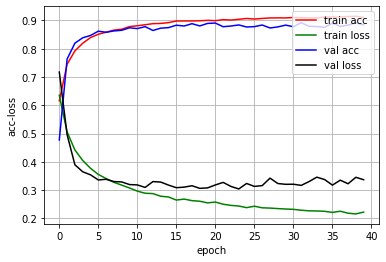

In [10]:
for i in range(1, 11):
    df1 = pd.read_csv('CV_dataset_DL/train{}.csv'.format(i))
    df2 = pd.read_csv('CV_dataset_DL/validation{}.csv'.format(i))
    
    df1,df2 = calculate_LR(df1,df2)
    df1,df2 = calculate_PA(df1,df2)
    
    df1, df2 = Encoding(df1, df2)

    df1 = df1.drop(labels=['nutation', 'name', 'seq'],axis=1)
    df2 = df2.drop(labels=['nutation', 'name', 'seq'],axis=1)
    
    y_train, y_test, X_train_1, X_test_1, X_train_2, X_test_2 = createTrainTestData(df1, df2)
    
    print(len(df1), 'train sequences')
    print(len(df2), 'test sequences')

    print('Pad sequences (samples x time)')
    X_test_1 = sequence.pad_sequences(X_test_1, maxlen=maxlen)
    X_train_1 = sequence.pad_sequences(X_train_1, maxlen=maxlen)
    print('X_test_1 shape:', X_test_1.shape)
    print('X_train_1 shape:', X_train_1.shape)

    print('X_test_2 shape:', X_test_2.shape)
    print('X_train_2 shape:', X_train_2.shape)


    print('Build model...')
    
    
    #单独机器学习
    no_reject(X_train_2, y_train.reshape(1,-1)[0], X_test_2, y_test.reshape(1,-1)[0], lgb.LGBMClassifier(), 0, 'CV_40epoch_2/LGBM_all_try_{}.csv'.format(i))
    no_reject(X_train_2, y_train.reshape(1,-1)[0], X_test_2, y_test.reshape(1,-1)[0], lgb.LGBMClassifier(), 20, 'CV_40epoch_2/LGBM_all_try_selected_{}.csv'.format(i))
    
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_length))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_length))
    model.add(BatchNormalization())
    model.add(LSTM(lstm_output_size, dropout=0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    
    history = LossHistory()
    
    model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])
    
    #模型评估
    score = model.evaluate(X_test_1, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    #绘制acc-loss曲线
    history.loss_plot('epoch')
    
    ## lstm层输出的70个
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
    train_output = intermediate_layer_model.predict(X_train_1)

    ## 共70+1085个

    X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
    X_train_3

    ## lstm层输出的70个
    test_output = intermediate_layer_model.predict(X_test_1)

    ## 共70+1085个

    X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
    X_test_3

    no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'CV_40epoch_2/cv_{}.csv'.format(i))
    
    
    ## lstm层输出的70个
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
    train_output = intermediate_layer_model.predict(X_train_1)

    ## 共70+20个

    X_train_3 = pd.concat([pd.DataFrame(train_output),pd.DataFrame(rfe.transform(X_train_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
    X_train_3

    ## lstm层输出的70个
    test_output = intermediate_layer_model.predict(X_test_1)

    ## 共70+20个

    X_test_3 = pd.concat([pd.DataFrame(test_output),pd.DataFrame(rfe.transform(X_test_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
    X_test_3

    no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'CV_40epoch_2/cv_{}_20_selected.csv'.format(i))

In [4]:
#变量初始化
seed=113

# Embedding
max_features = 21
maxlen = 1500
embedding_size = 128

# Convolution
#filter_length = 3
nb_filter = 64
pool_length = 2

# LSTM
# lstm_output_size = 20
lstm_output_size = 70

# Training
batch_size = 128
nb_epoch = 30

#特征选择
rfe = joblib.load('Feature_selected_1/lightgbm_feature_select_20.rfe')

筛选特征的个数选择

In [5]:
for i in range(1, 11):
    df1 = pd.read_csv('CV_dataset_DL/train{}.csv'.format(i))
    df2 = pd.read_csv('CV_dataset_DL/validation{}.csv'.format(i))
    
    df1,df2 = calculate_LR(df1,df2)
    df1,df2 = calculate_PA(df1,df2)
    
    df1, df2 = Encoding(df1, df2)

    df1 = df1.drop(labels=['nutation', 'name', 'seq'],axis=1)
    df2 = df2.drop(labels=['nutation', 'name', 'seq'],axis=1)
    
    y_train, y_test, X_train_1, X_test_1, X_train_2, X_test_2 = createTrainTestData(df1, df2)
    
    no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'compare/LGBM_all_{}.csv'.format(i))
    no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 10, filename = 'compare/LGBM_all_10_{}.csv'.format(i))
    no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 20, filename = 'compare/LGBM_all_20_{}.csv'.format(i))
    no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 50, filename = 'compare/LGBM_all_50_{}.csv'.format(i))
    no_reject(X_train = X_train_2, y_train = y_train.reshape(1,-1)[0], X_test = X_test_2, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 100, filename = 'compare/LGBM_all_100_{}.csv'.format(i))

28494 train sequences
3167 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3167, 1500)
X_train_1 shape: (28494, 1500)
X_test_2 shape: (3167, 1085)
X_train_2 shape: (28494, 1085)
Build model...
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 745, 64)           256       
____________________________________________

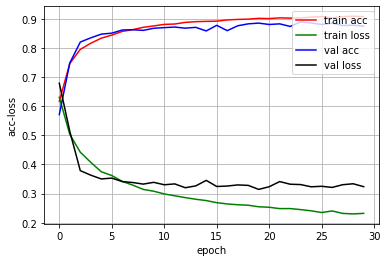

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 745, 64)           256       
____________________________________________

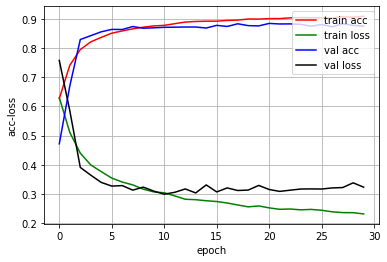

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 745, 64)           256       
____________________________________________

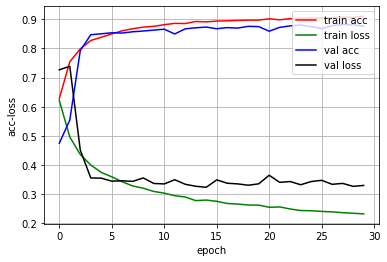

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1500, 128)         0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 745, 64)           256       
____________________________________________

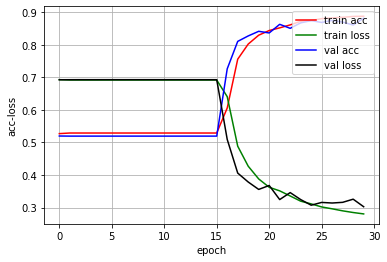

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_10 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 745, 64)           256       
____________________________________________

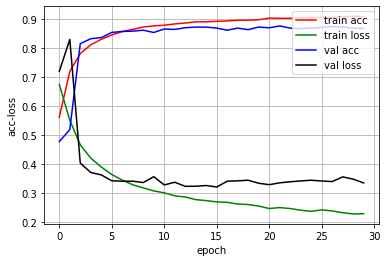

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 745, 64)           256       
____________________________________________

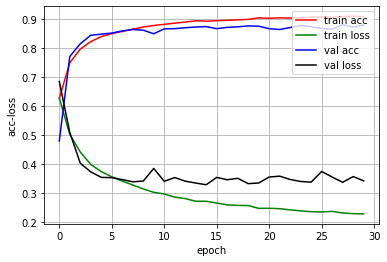

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_14 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 745, 64)           256       
____________________________________________

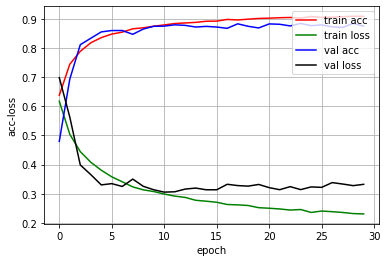

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_16 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 745, 64)           256       
____________________________________________

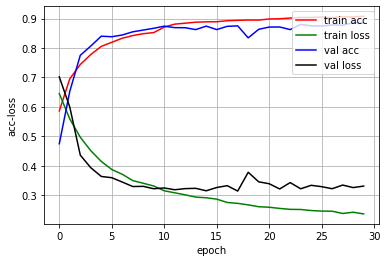

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1500, 128)         2688      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 745, 64)           256       
____________________________________________

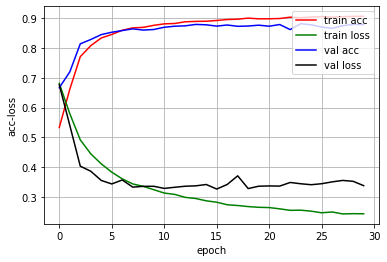

28495 train sequences
3166 test sequences
Pad sequences (samples x time)
X_test_1 shape: (3166, 1500)
X_train_1 shape: (28495, 1500)
X_test_2 shape: (3166, 1085)
X_train_2 shape: (28495, 1085)
Build model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 1500, 128)         2688      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1500, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1491, 64)          81984     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 745, 64)           0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 745, 64)           256       
___________________________________________

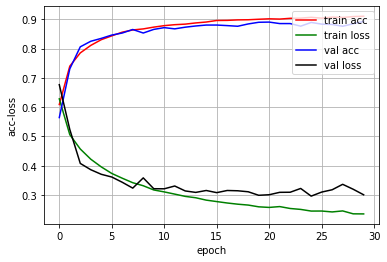

In [8]:
for i in range(1, 11):
    df1 = pd.read_csv('CV_dataset_DL/train{}.csv'.format(i))
    df2 = pd.read_csv('CV_dataset_DL/validation{}.csv'.format(i))
    
    df1,df2 = calculate_LR(df1,df2)
    df1,df2 = calculate_PA(df1,df2)
    
    df1, df2 = Encoding(df1, df2)

    df1 = df1.drop(labels=['nutation', 'name', 'seq'],axis=1)
    df2 = df2.drop(labels=['nutation', 'name', 'seq'],axis=1)
    
    y_train, y_test, X_train_1, X_test_1, X_train_2, X_test_2 = createTrainTestData(df1, df2)
    
    print(len(df1), 'train sequences')
    print(len(df2), 'test sequences')

    print('Pad sequences (samples x time)')
    X_test_1 = sequence.pad_sequences(X_test_1, maxlen=maxlen)
    X_train_1 = sequence.pad_sequences(X_train_1, maxlen=maxlen)
    print('X_test_1 shape:', X_test_1.shape)
    print('X_train_1 shape:', X_train_1.shape)

    print('X_test_2 shape:', X_test_2.shape)
    print('X_train_2 shape:', X_train_2.shape)


    print('Build model...')
    
    
    #单独机器学习
    no_reject(X_train_2, y_train.reshape(1,-1)[0], X_test_2, y_test.reshape(1,-1)[0], lgb.LGBMClassifier(), 0, 'CV_30epoch_2/LGBM_all_try_{}.csv'.format(i))
    no_reject(X_train_2, y_train.reshape(1,-1)[0], X_test_2, y_test.reshape(1,-1)[0], lgb.LGBMClassifier(), 20, 'CV_30epoch_2/LGBM_all_try_selected_{}.csv'.format(i))
    
    model = Sequential()
    model.add(Embedding(max_features, embedding_size, input_length=maxlen))
    model.add(Dropout(0.5))
    model.add(Conv1D(filters=nb_filter, kernel_size=10, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_length))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=nb_filter, kernel_size=5, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_length))
    model.add(BatchNormalization())
    model.add(LSTM(lstm_output_size, dropout=0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    model.summary()
    
    history = LossHistory()
    
    model.fit(X_train_1, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test_1, y_test), callbacks=[history])
    
    #模型评估
    score = model.evaluate(X_test_1, y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])

    #绘制acc-loss曲线
    history.loss_plot('epoch')
    
    ## lstm层输出的70个
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
    train_output = intermediate_layer_model.predict(X_train_1)

    ## 共70+1085个

    X_train_3 = pd.concat([pd.DataFrame(train_output),X_train_2.reset_index(drop=True)],axis=1)
    X_train_3

    ## lstm层输出的70个
    test_output = intermediate_layer_model.predict(X_test_1)

    ## 共70+1085个

    X_test_3 = pd.concat([pd.DataFrame(test_output),X_test_2.reset_index(drop=True)],axis=1)
    X_test_3

    no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'CV_30epoch_2/cv_{}.csv'.format(i))
    
    
    ## lstm层输出的70个
    intermediate_layer_model = Model(inputs=model.input,outputs=model.get_layer(index=-5).output)
    train_output = intermediate_layer_model.predict(X_train_1)

    ## 共70+20个

    X_train_3 = pd.concat([pd.DataFrame(train_output),pd.DataFrame(rfe.transform(X_train_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
    X_train_3

    ## lstm层输出的70个
    test_output = intermediate_layer_model.predict(X_test_1)

    ## 共70+20个

    X_test_3 = pd.concat([pd.DataFrame(test_output),pd.DataFrame(rfe.transform(X_test_2.reset_index(drop=True)), columns=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't'])],axis=1)
    X_test_3

    no_reject(X_train = X_train_3, y_train = y_train.reshape(1,-1)[0], X_test = X_test_3, y_test = y_test.reshape(1,-1)[0], model = lgb.LGBMClassifier(), selected = 0, filename = 'CV_30epoch_2/cv_{}_20_selected.csv'.format(i))